# AI-Driven Algo Trading Strategies

## PART I - Use LSTM Model to Predict Trading Signal

## Section 1: Import Libraries

In [1]:
#  Core Libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

#  TensorFlow / Keras for Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K  # Needed for custom loss

#  Scikit-learn for ML utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#  Others
from collections import Counter
from sklearn.utils import resample


## Section 2: Load and Preview the Data

In [4]:
# Load AAPL stock data (2022–2024)
df = pd.read_csv("AAPL_2022_2024.csv")

# Convert 'Date' column to datetime and set as index
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y", errors="coerce")
df.dropna(subset=["Date"], inplace=True)
df.set_index("Date", inplace=True)

# Preview the data
df.head()

,Close,High,Low,Open,Volume
Date,,,,,
2022-01-03,178.879929,179.734977,174.653889,174.771820,104487900
2022-01-04,176.609634,179.793920,176.039607,179.489254,99310400
2022-01-05,171.911865,177.071580,171.636682,176.521213,94537600
2022-01-06,169.042099,172.285352,168.688289,169.730058,96904000
2022-01-07,169.209152,171.145275,168.088758,169.916771,86709100


## Section 3: Visualize Raw Stock Price

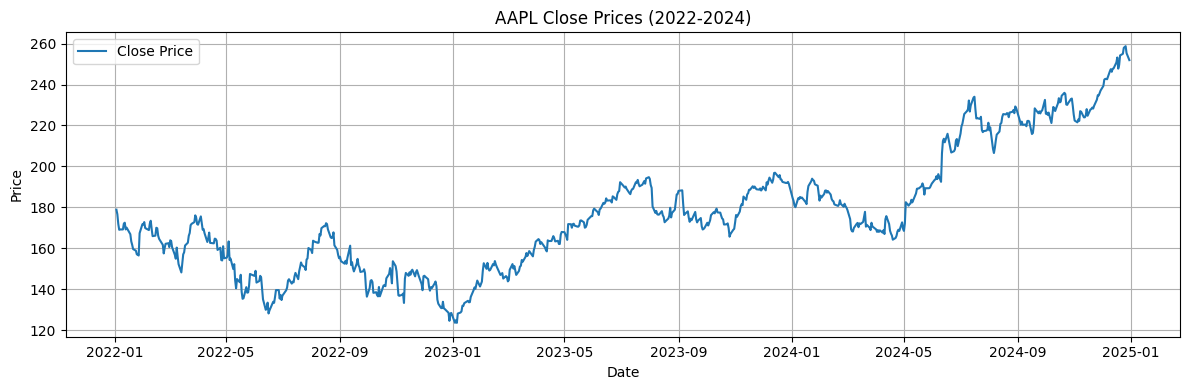

In [5]:
# Plot Raw Close Prices
plt.figure(figsize=(12, 4))
plt.plot(df["Close"], label="Close Price")
plt.title("AAPL Close Prices (2022-2024)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Section 4: Feature Engineering

In [6]:
# Feature Engineering
df["High_Low_Range"] = df["High"] - df["Low"]
df["Close_Change"] = df["Close"].pct_change()
df["SMA_10"] = df["Close"].rolling(10).mean()
df["SMA_50"] = df["Close"].rolling(50).mean()
df["Momentum_5"] = df["Close"] - df["Close"].shift(5)
df["Volatility_5"] = df["Close_Change"].rolling(5).std()

# Select Features
features = ["Close", "Volume", "High_Low_Range", "Momentum_5", "Volatility_5", "SMA_10", "SMA_50"]


## Section 5: Creating Labels (Buy/Sell/Hold)

In [7]:
# Create 3-Class Labels using Days = 2, Pct = 0.04
pct = 0.04
days = 2
ret = (df["Close"].shift(-days) - df["Close"]) / df["Close"]
df["Target"] = np.select(
    [ret > pct, ret < -pct],
    [1, 0],
    default=2
)

# Drop NaNs from features & label
df.dropna(subset=features + ["Target"], inplace=True)

# Scale Features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

## Section 6: Ensuring Reproducibility with Random Seed

In [9]:
# Set Random Seed for Reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

## Section 7: Sequence Creation for LSTM

In [11]:
# Create Sequences BEFORE balancing
window = 15
X_all, y_all = [], []
for i in range(len(df) - window - 1):
    X_seq = df[features].iloc[i:i + window].values
    y_seq = df["Target"].iloc[i + window]
    X_all.append(X_seq)
    y_all.append(y_seq)

X_all = np.array(X_all).astype(np.float32)
y_all = np.array(y_all).astype(int)

## Section 8: Balancing the Dataset (Oversampling)

In [12]:
# Balance Dataset by Oversampling if Needed

counter = Counter(y_all)
min_class_size = min(counter.values())
min_required = 30

if min_class_size < min_required:
    print("⚠️ Too few samples in at least one class, skipping balancing...")
    X, y = X_all, y_all
else:
    # Use oversampling instead of downsampling
    X_oversampled, y_oversampled = [], []
    max_class_size = max(counter.values())
    for cls in [0, 1, 2]:
        idx = np.where(y_all == cls)[0]
        resampled_idx = resample(idx, replace=True, n_samples=max_class_size, random_state=seed)
        X_oversampled.extend(X_all[resampled_idx])
        y_oversampled.extend(y_all[resampled_idx])
    X = np.array(X_oversampled).astype(np.float32)
    y = tf.keras.utils.to_categorical(np.array(y_oversampled), num_classes=3)


## Section 9: Focal Loss for Handling Class Imbalance

In [13]:
# Define Focal Loss
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma) * y_true + (1 - alpha) * K.pow(y_pred, gamma) * (1 - y_true)
        loss = weight * cross_entropy
        return K.mean(loss, axis=-1)
    return focal_loss_fixed


## Section 10: Defining and Training the LSTM Model

In [14]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=seed)

# Define LSTM Model
model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

# Compile Model with Focal Loss
model.compile(
    loss=focal_loss(gamma=2., alpha=.25),
    optimizer='adam',
    metrics=['accuracy']
)

# Train Model with early stopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)
history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


c:\Users\BAISAMPAYAN\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.3600 - loss: 0.0632 - val_accuracy: 0.4551 - val_loss: 0.0619
Epoch 2/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4240 - loss: 0.0615 - val_accuracy: 0.4684 - val_loss: 0.0614
Epoch 3/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4369 - loss: 0.0613 - val_accuracy: 0.4518 - val_loss: 0.0608
Epoch 4/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4683 - loss: 0.0608 - val_accuracy: 0.5116 - val_loss: 0.0603
Epoch 5/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4943 - loss: 0.0597 - val_accuracy: 0.4917 - val_loss: 0.0596
Epoch 6/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5081 - loss: 0.0588 - val_accuracy: 0.4751 - val_loss: 0.0595
Epoch 7/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5222 - loss: 0.0574 - val_accuracy: 0.4850 - val_loss: 0.0591
Epoch 8/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5355 - loss: 0.0570 - val_accuracy: 0.5249 - val_lo

## Section 11: Evaluate Model

In [15]:
# Evaluate Model
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)
acc = accuracy_score(y_true, y_pred)
print(f"\n Final Test Accuracy: {acc:.2f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

 Final Test Accuracy: 0.87

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93       137
           1       0.78      1.00      0.87       100
           2       0.93      0.70      0.80       139

    accuracy                           0.87       376
   macro avg       0.87      0.88      0.87       376
weighted avg       0.88      0.87      0.87       376


Confusion Matrix:
 [[130   0   7]
 [  0 100   0]
 [ 13  29  97]]


### Visualize Confusion Matrics

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


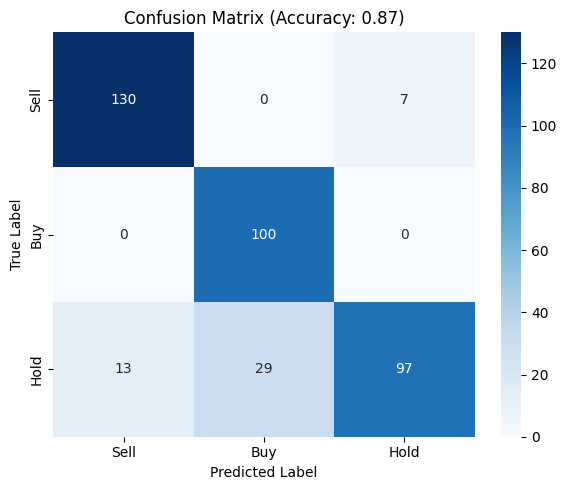

In [16]:
# Visualize Evaluation Metrics

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Convert predictions to labels
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix and accuracy
cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Sell", "Buy", "Hold"], yticklabels=["Sell", "Buy", "Hold"])
plt.title(f"Confusion Matrix (Accuracy: {acc:.2f})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


### Visualize True vs Predicted Classes

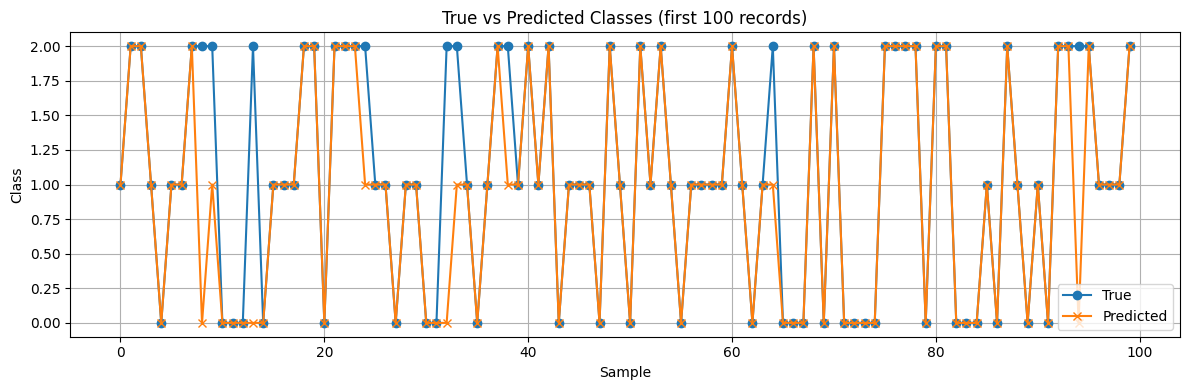

In [17]:
#  Plot Predictions vs Actual (optional)
plt.figure(figsize=(12, 4))
plt.plot(y_true[:100], label='True', marker='o')
plt.plot(y_pred[:100], label='Predicted', marker='x')
plt.title("True vs Predicted Classes (first 100 records)")
plt.xlabel("Sample")
plt.ylabel("Class")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Predict Next Trading Signal

In [18]:
#  Predict Next Trading Signal
latest_seq = df[features].iloc[-window:].values.reshape(1, window, len(features)).astype(np.float32)
next_prob = model.predict(latest_seq)[0]
next_signal = np.argmax(next_prob)
print(f"\n Next Trading Signal: {['Sell', 'Buy', 'Hold'][next_signal]} (Confidence: {next_prob[next_signal]:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step

 Next Trading Signal: Hold (Confidence: 0.99)


### Visualize Buy, Sell, Hold Signals on Stock Chart

C:\Users\BAISAMPAYAN\AppData\Local\Temp\ipykernel_19412\2700334410.py:31: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\BAISAMPAYAN\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


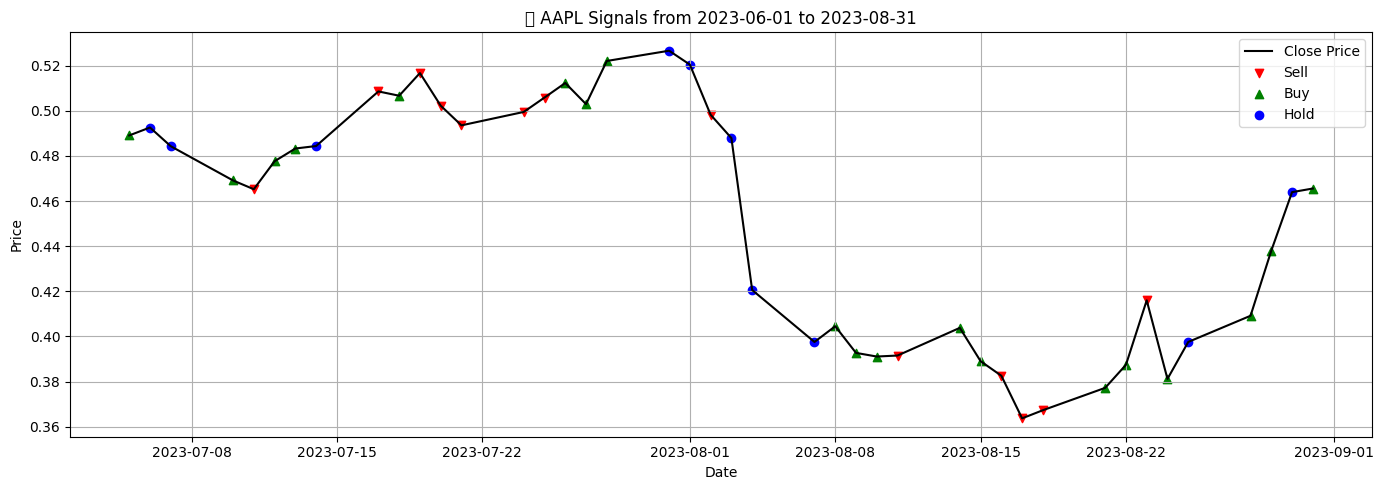

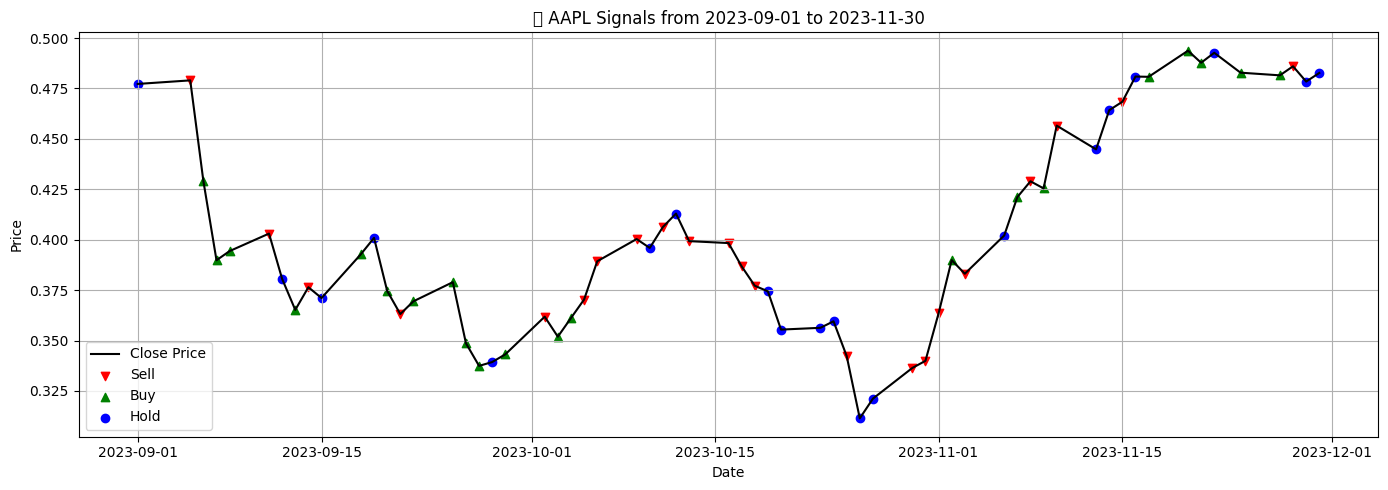

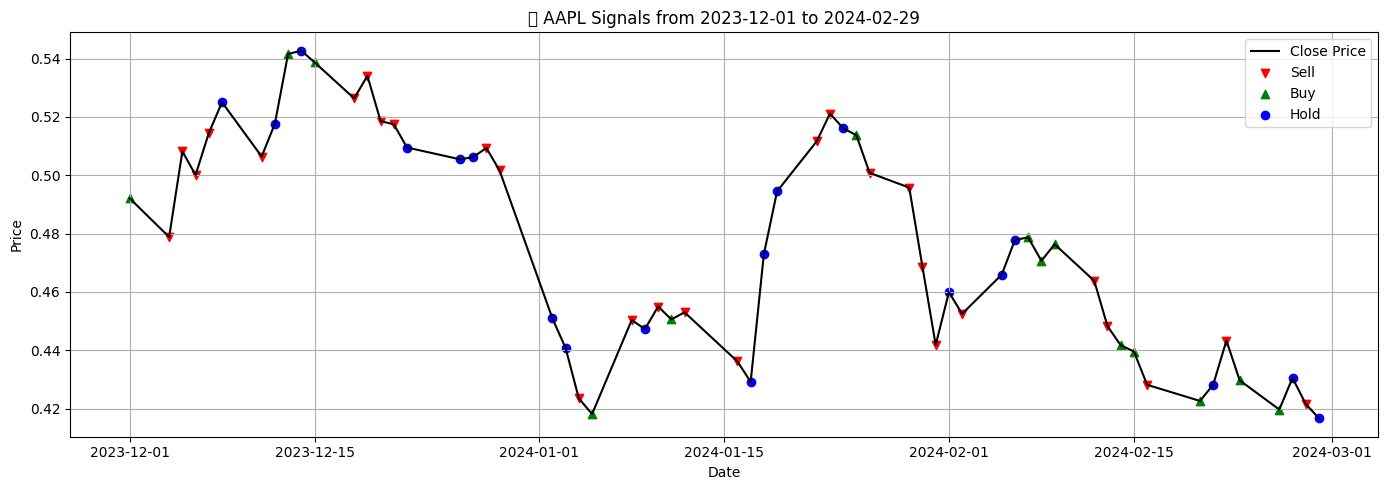

In [19]:
#  Prepare Data with Predictions
df_pred_only = df.iloc[-len(y_pred):].copy()
df_pred_only["Pred"] = y_pred

#  Define time ranges (adjust as needed)
ranges = [
    ("2023-06-01", "2023-08-31"),
    ("2023-09-01", "2023-11-30"),
    ("2023-12-01", "2024-02-29")
]

#  Plot each time slice as a separate full-width figure
for start, end in ranges:
    df_slice = df_pred_only.loc[start:end]

    plt.figure(figsize=(14, 5))
    plt.plot(df_slice.index, df_slice["Close"], label="Close Price", color="black")

    plt.scatter(df_slice[df_slice["Pred"] == 0].index, df_slice[df_slice["Pred"] == 0]["Close"],
                label="Sell", marker="v", color="red")
    plt.scatter(df_slice[df_slice["Pred"] == 1].index, df_slice[df_slice["Pred"] == 1]["Close"],
                label="Buy", marker="^", color="green")
    plt.scatter(df_slice[df_slice["Pred"] == 2].index, df_slice[df_slice["Pred"] == 2]["Close"],
                label="Hold", marker="o", color="blue")

    plt.title(f"📅 AAPL Signals from {start} to {end}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Section 12: Backtesting

In [20]:
def backtest_long_only(df, signal_col="Pred", price_col="Close", 
                       initial_capital=100000, transaction_cost=0.0005):
    """
    Simulate long-only strategy using model signals: Buy (1), Sell (0), Hold (2).
    Buy → enter position; Sell → exit to cash; Hold → maintain.
    """

    df_bt = df.copy()
    df_bt = df_bt[df_bt[signal_col].notna()].copy()  # Only prediction period

    capital = initial_capital
    position = 0  # 0 = no stock, >0 = shares held
    cash = capital
    portfolio_value = []

    for i in range(len(df_bt)):
        signal = df_bt[signal_col].iloc[i]
        price = df_bt[price_col].iloc[i]

        if signal == 1 and position == 0:  # Buy
            position = (cash * (1 - transaction_cost)) / price
            cash = 0

        elif signal == 0 and position > 0:  # Sell
            cash = position * price * (1 - transaction_cost)
            position = 0

        # Portfolio value = cash + market value of holdings
        total = cash + position * price
        portfolio_value.append(total)

    df_bt["Portfolio Value"] = portfolio_value
    return df_bt


#### Backtesting Results: Portfolio Value

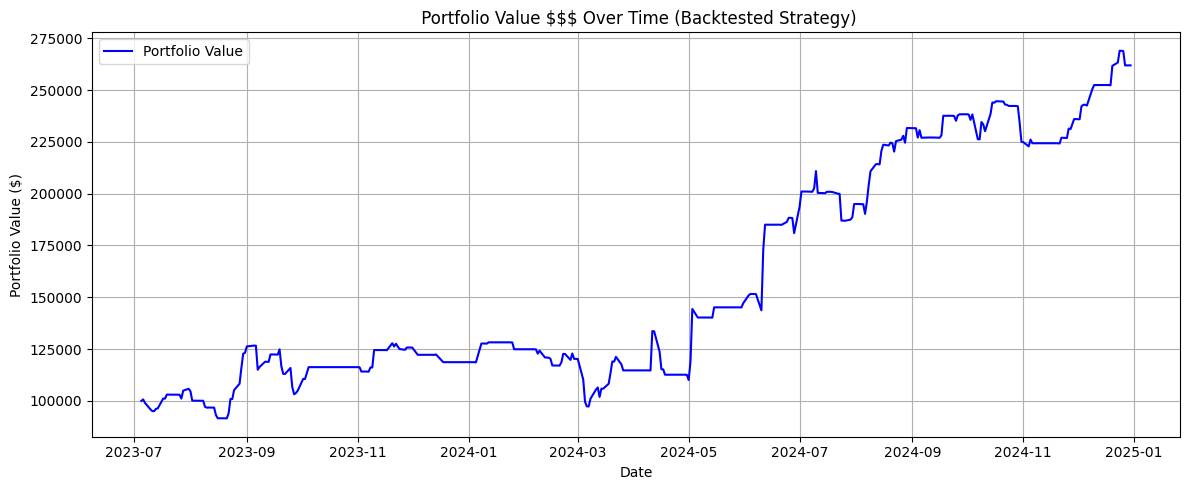

📈 Final Portfolio Value: $261,960.51 (from $100,000)


In [21]:
df_bt_result = backtest_long_only(df_pred_only)

#  Plot Equity Curve
plt.figure(figsize=(12, 5))
plt.plot(df_bt_result.index, df_bt_result["Portfolio Value"], label="Portfolio Value", color="blue")
plt.title(" Portfolio Value $$$ Over Time (Backtested Strategy)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#  Final return
final_value = df_bt_result["Portfolio Value"].iloc[-1]
print(f"📈 Final Portfolio Value: ${final_value:,.2f} (from $100,000)")


#### Compute Portfolio Value, Return, Volatility, Sharpe Ratio and Max Drawdown

In [22]:
def compute_performance_metrics(df_bt, initial_capital=100000, risk_free_rate=0.0):
    df_bt = df_bt.copy()
    df_bt["Daily Return"] = df_bt["Portfolio Value"].pct_change()
    
    cumulative_return = df_bt["Portfolio Value"].iloc[-1] / initial_capital - 1
    avg_daily_return = df_bt["Daily Return"].mean()
    std_daily_return = df_bt["Daily Return"].std()
    annualized_volatility = std_daily_return * np.sqrt(252)

    # Sharpe Ratio (assumes daily returns and 252 trading days)
    sharpe_ratio = (avg_daily_return - risk_free_rate / 252) / std_daily_return * np.sqrt(252)

    # Max Drawdown
    rolling_max = df_bt["Portfolio Value"].cummax()
    drawdown = df_bt["Portfolio Value"] / rolling_max - 1
    max_drawdown = drawdown.min()

    return {
        "Final Portfolio Value": df_bt["Portfolio Value"].iloc[-1],
        "Cumulative Return": cumulative_return,
        "Annualized Volatility": annualized_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown
    }


#### Display Performance Matrices Values

In [23]:
metrics = compute_performance_metrics(df_bt_result)

print("\n Backtest Performance Summary")
for k, v in metrics.items():
    if isinstance(v, float):
        print(f"{k}: {v:,.4f}" if 'Value' not in k else f"{k}: ${v:,.2f}")
    else:
        print(f"{k}: {v}")



 Backtest Performance Summary
Final Portfolio Value: $261,960.51
Cumulative Return: 1.6196
Annualized Volatility: 0.4418
Sharpe Ratio: 1.6789
Max Drawdown: -0.2415


#### Plot Portfolio Value

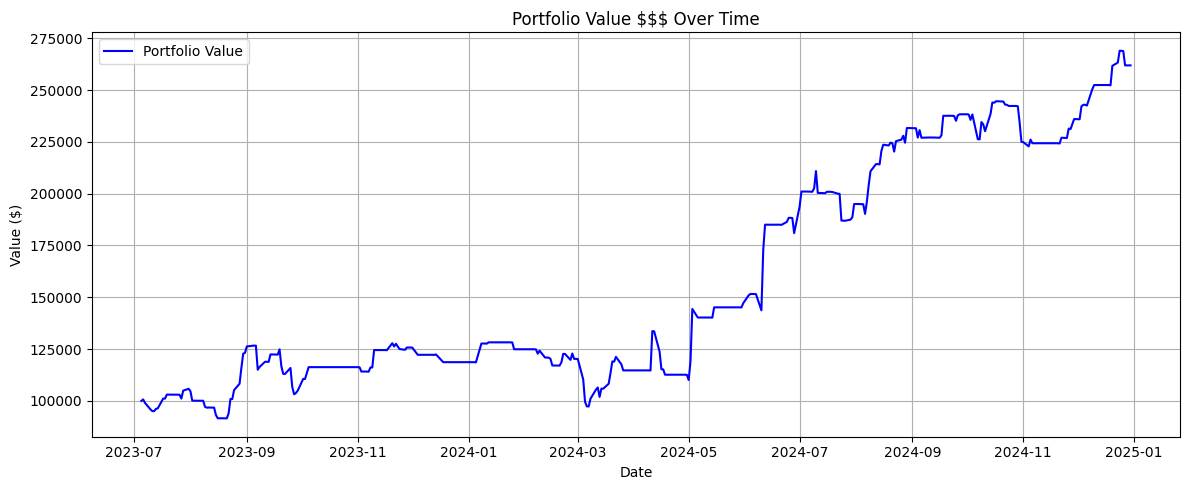

In [24]:
plt.figure(figsize=(12, 5))
plt.plot(df_bt_result.index, df_bt_result["Portfolio Value"], color="blue", label="Portfolio Value")
plt.title("Portfolio Value $$$ Over Time")
plt.xlabel("Date")
plt.ylabel("Value ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### Plot Drawdown Over Time

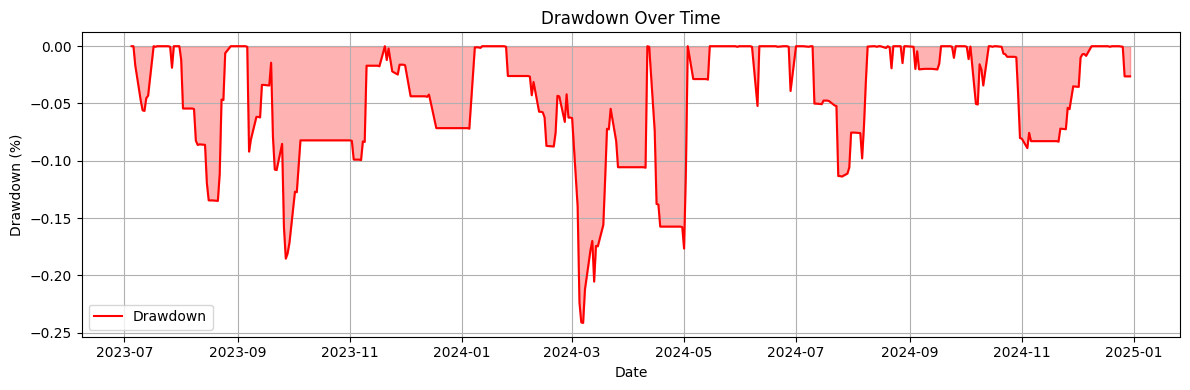

In [25]:
rolling_max = df_bt_result["Portfolio Value"].cummax()
drawdown = df_bt_result["Portfolio Value"] / rolling_max - 1

plt.figure(figsize=(12, 4))
plt.plot(drawdown.index, drawdown, color="red", label="Drawdown")
plt.fill_between(drawdown.index, drawdown, 0, color="red", alpha=0.3)
plt.title("Drawdown Over Time")
plt.xlabel("Date")
plt.ylabel("Drawdown (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### Plot Performance Metrics

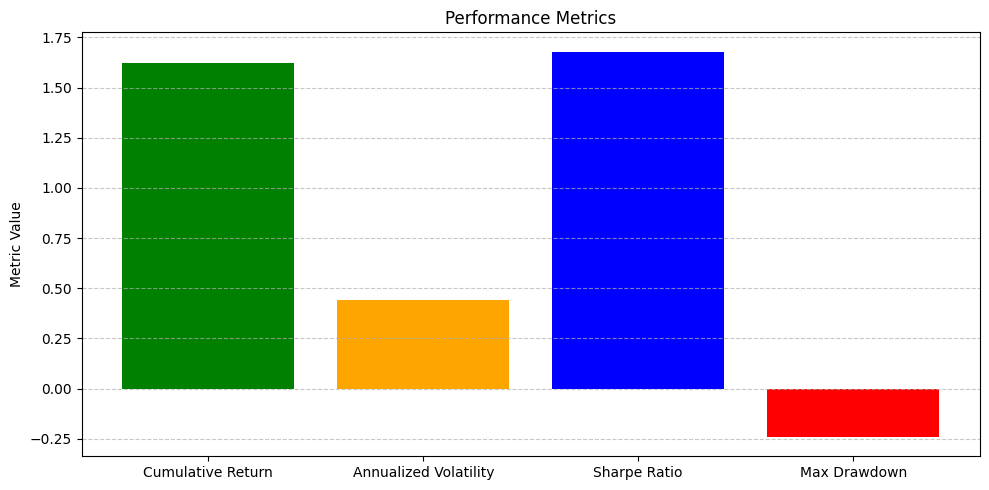

In [26]:
# Filter numeric metrics for plotting
plot_metrics = {k: v for k, v in metrics.items() if isinstance(v, float) and "Value" not in k}

plt.figure(figsize=(10, 5))
plt.bar(plot_metrics.keys(), plot_metrics.values(), color=['green', 'orange', 'blue', 'red'])
plt.title("Performance Metrics")
plt.ylabel("Metric Value")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Section 13: Exporting the Trained Model and Scaler (for Deployment)
In this final section, we save the trained LSTM model (`lstm_model.h5`) and the fitted `MinMaxScaler` (`scaler.pkl`) so they can be reused for live predictions in Part II.


In [27]:
import joblib

# Save the trained model
model.save('lstm_model.h5')
print("Model saved as 'lstm_model.h5'")

# Save the fitted scaler (used to transform features)
joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved as 'scaler.pkl'")

# Explain to user
print("These files will be used in Part II for live predictions.")


Model saved as 'lstm_model.h5'
Scaler saved as 'scaler.pkl'
These files will be used in Part II for live predictions.
